# Download and extract data

In [1]:
!wget http://www.konect.cc/files/download.tsv.ca-cit-HepPh.tar.bz2
!tar -xf download.tsv.ca-cit-HepPh.tar.bz2
!rm download.tsv.ca-cit-HepPh.tar.bz2

--2021-02-02 16:22:06--  http://konect.cc/files/download.tsv.dblp_coauthor.tar.bz2
Resolving konect.cc (konect.cc)... 138.48.20.248
Connecting to konect.cc (konect.cc)|138.48.20.248|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137231649 (131M) [application/x-bzip2]
Saving to: 'download.tsv.dblp_coauthor.tar.bz2'

100%[======================================>] 137,231,649 49.5MB/s   in 2.6s   

2021-02-02 16:22:09 (49.5 MB/s) - 'download.tsv.dblp_coauthor.tar.bz2' saved [137231649/137231649]



# Setup

In [1]:
from importlib import reload
import os

import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker 
import networkx as nx
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
from tqdm.auto import tqdm

import lp
reload(lp)

temp_path = '02/temp'

cutoff = 2

# Get network

In [7]:
edgelist = lp.konect_to_pandas('02 ca-cit-HepPh/out.ca-cit-HepPh', sep=' ')
edgelist.to_pickle(f'{temp_path}/edgelist.pkl')
edgelist

,u,v,datetime
0,1,2,1999-07-04 22:00:00
1,1,3,1999-07-04 22:00:00
3,1,4,1999-07-04 22:00:00
4,1,5,1999-07-04 22:00:00
5,1,6,1999-07-04 22:00:00
...,...,...,...
4596773,27994,27995,1998-05-11 22:00:00
4596787,28054,28055,1996-08-13 22:00:00
4596791,28061,28062,1999-06-15 22:00:00
4596795,28072,28073,1994-04-17 22:00:00


In [8]:
%%time
multigraph = nx.from_pandas_edgelist(
  edgelist, source='u', target='v', edge_attr=True, create_using=nx.MultiGraph)
nx.write_gpickle(multigraph, f'{temp_path}/multigraph.pkl')

CPU times: user 11.1 s, sys: 419 ms, total: 11.5 s
Wall time: 11.5 s


## Figure: Event distribution with maturing and probing intervals indicated

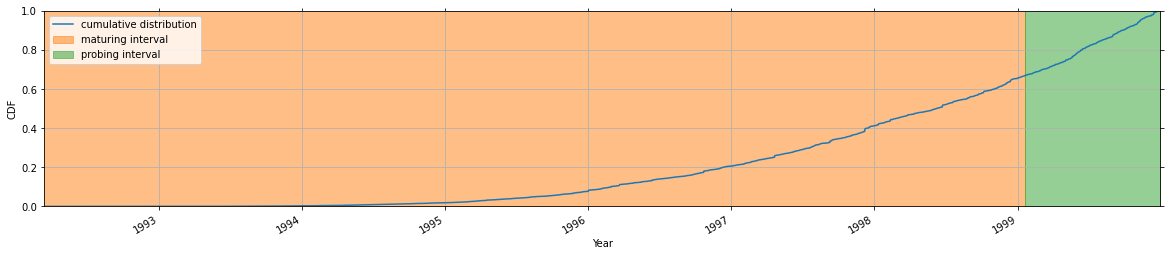

In [4]:
lp.plot_interval(joblib.load(f'{temp_path}/edgelist.pkl')['datetime'])

# Maturing and probing

In [139]:
%%time
edgelist_mature, edgelist_probe = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'))

index, y = lp.get_instances(
  edgelist_mature=edgelist_mature, edgelist_probe=edgelist_probe, 
  cutoff=cutoff, verbose=True)

Determine targets:   0%|          | 0/23454020 [00:00<?, ?it/s]

CPU times: user 8min 46s, sys: 8.86 s, total: 8min 55s
Wall time: 8min 54s


In [145]:
%%time
edgelist_mature.to_pickle(f'{temp_path}/edgelist_mature.pkl')
np.save(f'{temp_path}/index', index)
np.save(f'{temp_path}/y', y)

CPU times: user 2.7 ms, sys: 149 ms, total: 152 ms
Wall time: 224 ms


## Metric: class imbalance

In [48]:
pd.Series(y).value_counts()

False    23295070
True       158950
dtype: int64

In [49]:
pd.Series(y).value_counts(normalize=True)

False    0.993223
True     0.006777
dtype: float64

# Network characteristics

In [4]:
for folder in ['stats', 'path_distribution']: 
  os.makedirs(f'{temp_path}/{folder}', exist_ok=True)

# Complete graph
path_distribution, stat = lp.report(
  joblib.load(f'{temp_path}/multigraph_complete.pkl'))
joblib.dump(stat, f'{temp_path}/stats/complete.pkl')
joblib.dump(path_distribution, f'{temp_path}/path_distribution/complete.pkl')

# Graph of maturing interval
graph_mature = nx.from_pandas_edgelist(
  joblib.load(f'{temp_path}/edgelist_mature.pkl'), source='u', target='v', 
  edge_attr=True, create_using=nx.MultiGraph)

path_distribution, stat = lp.report(graph_mature)
joblib.dump(stat, f'{temp_path}/stats/mature.pkl')
joblib.dump(path_distribution, f'{temp_path}/path_distribution/mature.pkl')

['02 ca-cit-HepPh/temp/path_distribution/mature.pkl']

## Table: Statistics

In [123]:
pd.DataFrame.from_dict(
  {file.split('.')[0]: joblib.load(f'{temp_path}/stats/{file}') 
   for file in os.listdir(f'{temp_path}/stats')}, orient='index')

,nodes,nodes (GC),edges,edges (GC),edges (simplegraph),"edges (simplegraph, GC)",average number of edges between connected node pairs,density,density (GC),density (simplegraph),"density (simplegraph, GC)",assortativity,assortativity (simplegraph),diameter,average path length,average clustering coefficient
complete,16959,16913,2322259,2322221,1194440,1194408,0.514344,0.016150,0.016237,0.008307,0.008352,0.167886,0.059906,7,2.858306,0.606845
mature,13651,13614,1552317,1552280,837731,837702,0.539665,0.016661,0.016752,0.008992,0.009040,0.196655,0.079825,7,2.899287,0.620334


## Figure: Path distributions

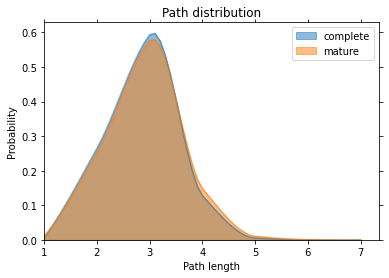

In [78]:
df = pd.DataFrame(
  {file.split('.')[0]: (
    pd.Series(joblib.load(f'{temp_path}/path_distribution/{file}')[:,1])
    .transform(lambda x: x/x.sum()))
   for file in os.listdir(f'{temp_path}/path_distribution')})
with plt.rc_context({'xtick.top': True, 'ytick.right': True}):
  (df
   .reindex(np.arange(0, df.index.max(), .1))
   .interpolate('akima', limit_area='inside')
   .dropna(how='all')
  ).plot(kind='area', xlim=(1), ylim=(0), stacked=False, alpha=.5, 
         title='Path distribution', xlabel='Path length', ylabel='Probability')

## Figure: Time strategies

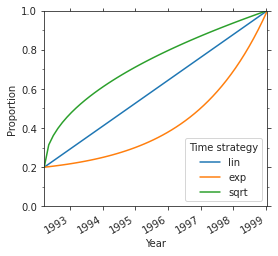

In [131]:
edgelist_mature, _ = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'))
lp.plot_time_strategies(edgelist_mature['datetime'])

## Figure: Time output distribution

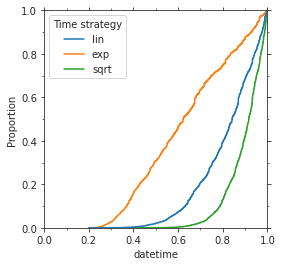

In [122]:
edgelist_mature, _ = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'))
sns.set_style('ticks')
data = pd.concat(
  {time_str: time_func(edgelist_mature['datetime']) 
   for time_str, time_func in lp.TIME_STRATEGIES.items()}, 
  names=['Time strategy', 'index']
).reset_index('Time strategy').reset_index(drop=True)
with plt.rc_context({'xtick.top': True, 'ytick.right': True, 
                     'figure.figsize': (4,4)}):
  ax = sns.ecdfplot(data=data, x='datetime', hue='Time strategy')
  ax.set_xlim((0,1))
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.1))

# Sample

In [135]:
%%time
index_sampled, index_y = lp.balanced_sample(
  index=np.load(f'{temp_path}/index.npy'), 
  y=np.load(f'{temp_path}/y.npy'), 
  size=10000)

np.save(f'{temp_path}/index_sampled', index_sampled)
np.save(f'{temp_path}/y_sampled', index_y)

CPU times: user 487 ms, sys: 215 ms, total: 702 ms
Wall time: 4.24 s


# Learn

## Adamic Adar

### Time agnostic

In [2]:
%%time
adamic_adar_time_agnostic = lp.adamic_adar_time_agnostic(
  edgelist=joblib.load(f'{temp_path}/edgelist_mature.pkl'),
  samples=np.load(f'{temp_path}/index_sampled.npy'))
joblib.dump([adamic_adar_time_agnostic], 
            f'{temp_path}/features/adamic-adar-time-agnostic.pkl')

CPU times: user 9.23 s, sys: 142 ms, total: 9.37 s
Wall time: 9.41 s


['02/temp/features/adamic-adar-time-agnostic.pkl']

### Time aware

In [3]:
adamic_adar_time_aware = lp.adamic_adar_time_aware(
  edgelist=joblib.load(f'{temp_path}/edgelist_mature.pkl'),
  samples=np.load(f'{temp_path}/index_sampled.npy'),
  verbose=True
)

joblib.dump(adamic_adar_time_aware, 
            f'{temp_path}/features/adamic-adar-time-aware.pkl')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

['02/temp/features/adamic-adar-time-aware.pkl']

### Some plots

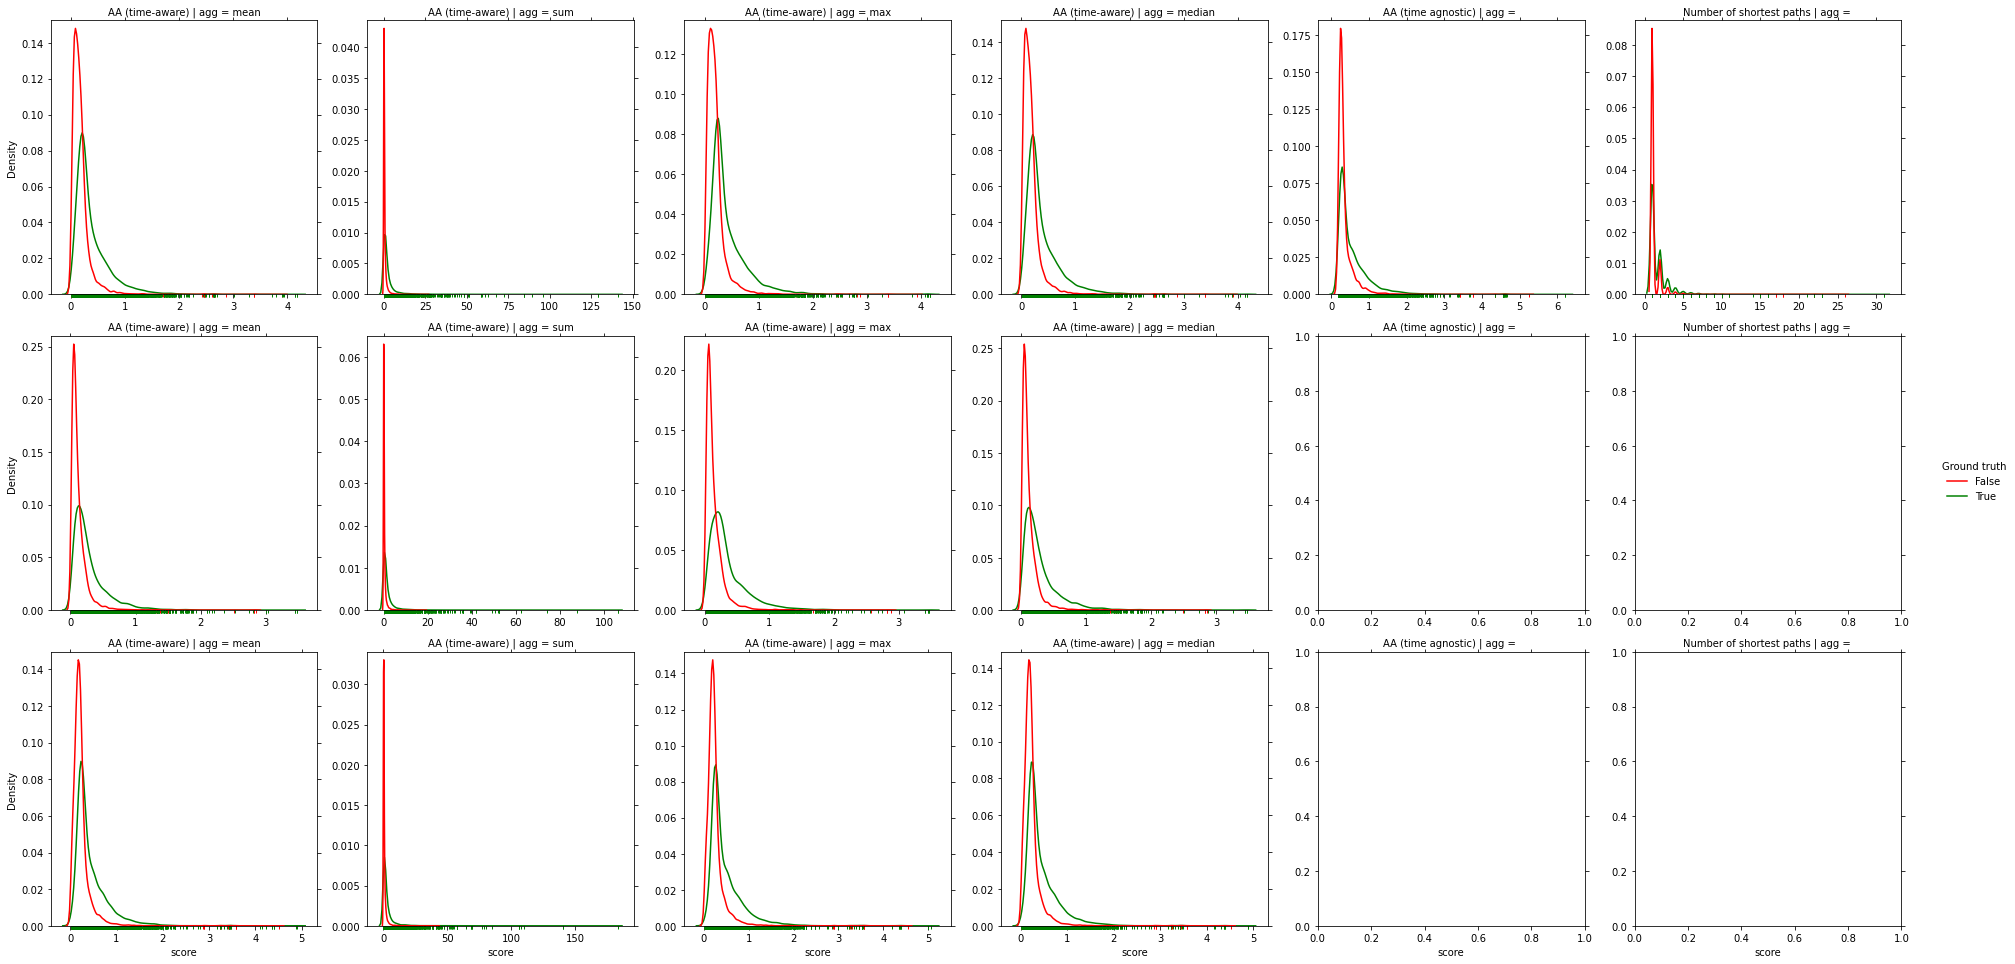

In [110]:
with plt.rc_context({'xtick.top': True, 'ytick.right': True}):
  g = sns.displot(
    (pd.concat(
      [pd.DataFrame({'Ground truth': np.load(f'{temp_path}/samples_y.npy'), 
                     **experiment}) for experiment in experiments],
      ignore_index=True)
     .fillna({'Time strategy': 'lin'})
     .assign(Feature = lambda x: (
       x['Feature'] + ' | agg = ' + x['Aggregation strategy'].fillna('')))), 
    x='score', hue='Ground truth', col='Feature', row='Time strategy', 
    kind='kde', palette=['red', 'green'], height=4.5, rug=True,
    rug_kws=dict(height=-.01, clip_on=False), 
    facet_kws=dict(sharex=False, sharey=False, despine=False))
  g.set_titles('{col_name}')

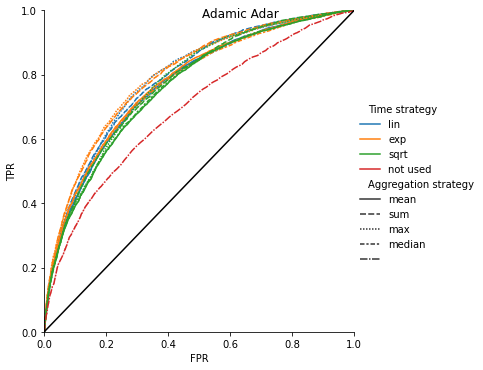

In [71]:
data = pd.DataFrame([
  dict(FPR=fpr, TPR=tpr, **experiment)
  for experiment in experiments
  for fpr, tpr, _ in zip(*roc_curve(samples_y, experiment['score']))]
).drop(columns='score')

g = sns.relplot(
  data=data.fillna({'Time strategy': 'not used', 'Aggregation strategy': ''}), 
  x='FPR', y='TPR', hue='Time strategy', style='Aggregation strategy', aspect=1, 
  kind='line')
plt.axline((0,0), (1,1), c='black')
g.fig.suptitle('Adamic Adar')
g.set(xlim=(0,1), ylim=(0,1))

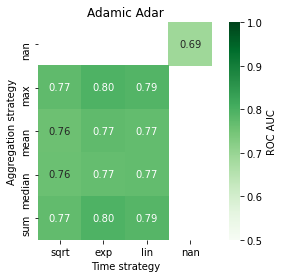

In [87]:
sns.heatmap(
  (pd.DataFrame(
    [{'ROC AUC': roc_auc_score(np.load(f'{temp_path}/samples_y.npy'), 
                               experiment['score']), **experiment} 
     for experiment in experiments])
   .fillna(dict(time='not used', agg=''))
   .pivot(index='Aggregation strategy', columns='Time strategy')
  )['ROC AUC'].sort_values('median', axis='columns'),
  vmin=.5, vmax=1, annot=True, fmt='.2f', square=True, cmap='Greens',
  cbar_kws=dict(label='ROC AUC')
)
plt.title('Adamic Adar');

## Number of shortest path
Mind that only distance-2 node pairs are used at the moment.

In [89]:
# Slow method, but providing also shortest paths at greater distance:
# [len(list(nx.all_shortest_paths(multigraph_mature, *sample))) for sample in tqdm(np.load('temp/samples.npy'))]

def single_source_number_paths_length_2(graph: nx.Graph, source):
  result = dict()
  for nb in graph[source]:
    for nnb in graph[nb]:
      result[nnb] = result.get(nnb, 0) + 1
  return result

multigraph_mature = nx.read_gpickle(f'{temp_path}/multigraph-mature.pkl')

paths__of_length_2_from_node_u = {
  node: single_source_number_paths_length_2(multigraph_mature, node) 
  for node in np.load(f'{temp_path}/samples.npy')[:,0]}

feature = [{
  'score': np.array(
    [result[u][v] for u, v in tqdm(np.load(f'{temp_path}/samples.npy'))]),
  'Feature': 'Number of shortest paths',
  'Aggregation strategy': np.nan,
  'Time strategy': np.nan}]

joblib.dump(feature, 
            f'{temp_path}/features/number-shortest-paths-time-unaware.pkl')

  0%|          | 0/20000 [00:00<?, ?it/s]

# Results

In [7]:
path = f'{temp_path}/features/'
experiments = list()
for file in os.listdir(path): 
  if file.endswith('.pkl'):
    experiments.extend(joblib.load(path + file))

## Figure: Score distribution

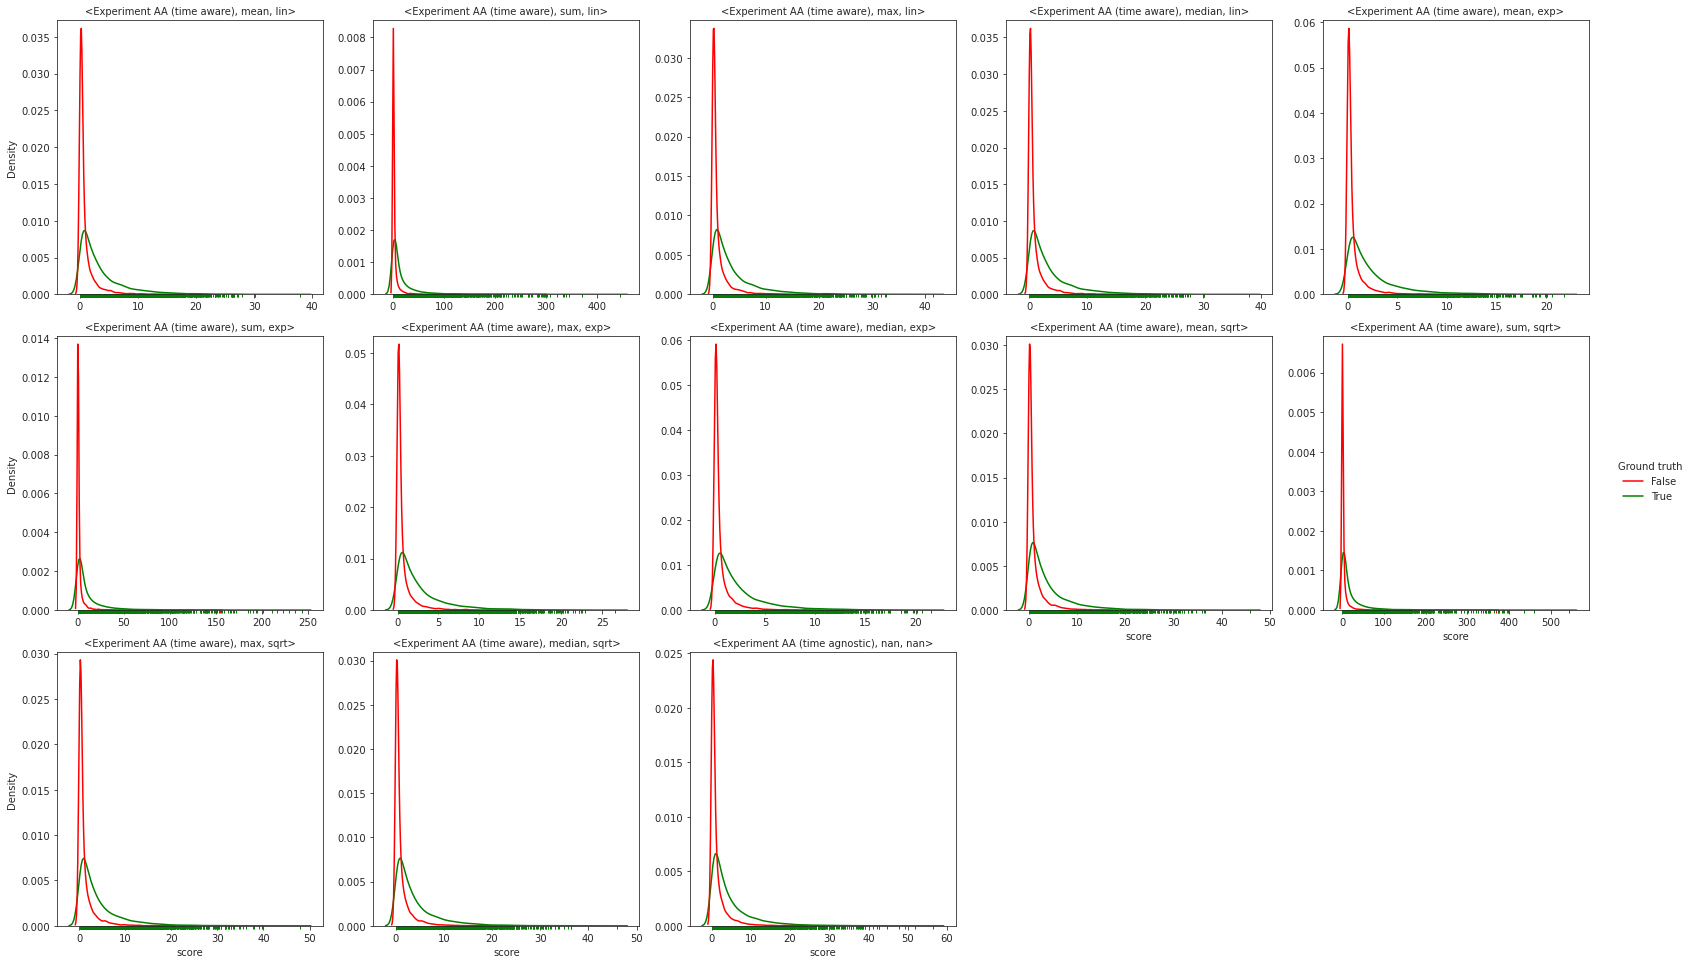

In [175]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
g = sns.displot(
  data=pd.DataFrame.from_dict(
    [{'Feature': experiment.__repr__(), 'score': score, 'Ground truth': y}
     for experiment in experiments
     for score, y in zip(experiment.scores, y_sampled)]),
  x='score', hue='Ground truth', col='Feature', kind='kde', 
  palette=['red', 'green'], height=4.5, rug=True, col_wrap=5,
  rug_kws=dict(height=-.01, clip_on=False), 
  facet_kws=dict(sharex=False, sharey=False, despine=False))
g.set_titles(col_template="{col_name}")

## Figure: ROC plot

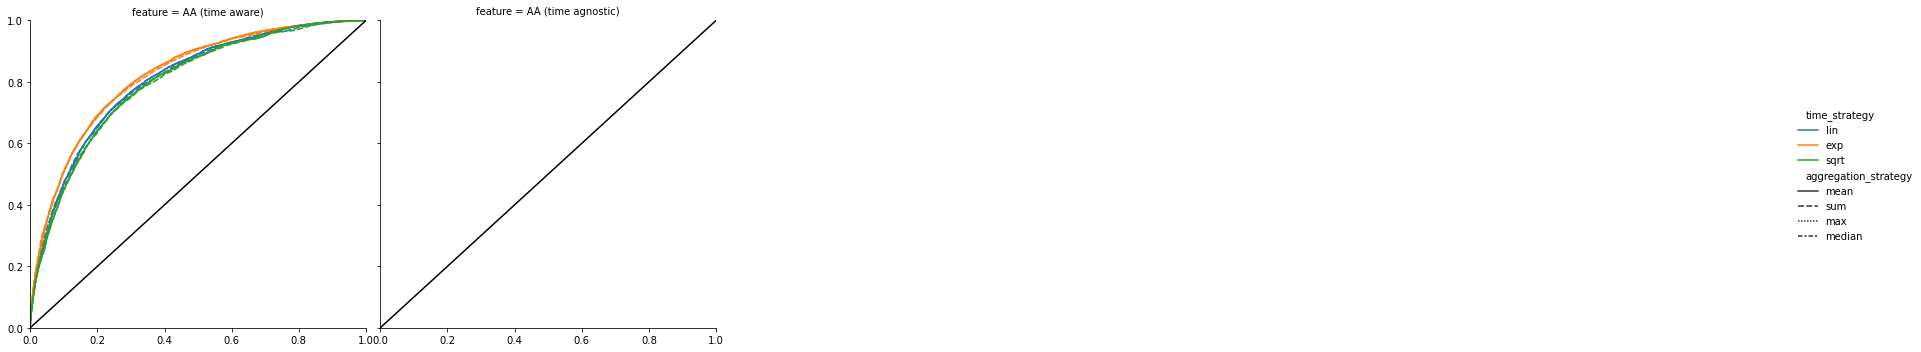

In [9]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
data = pd.DataFrame.from_dict(
    [{'Feature': experiment.__repr__(), 'FPR': fpr, 'TPR': tpr, 
      **experiment.get_parameters()}
     for experiment in experiments
     for fpr, tpr, _ 
     in zip(*sklearn.metrics.roc_curve(y_sampled, experiment.scores))])
g = sns.relplot(
  data=data, x='FPR', y='TPR', hue='time_strategy', 
  style='aggregation_strategy', col='feature', col_wrap=5, aspect=1, 
  kind='line')
g.map(plt.axline, xy1=(0,0), xy2=(1,1), c='black')
g.set(xlim=(0,1), ylim=(0,1))

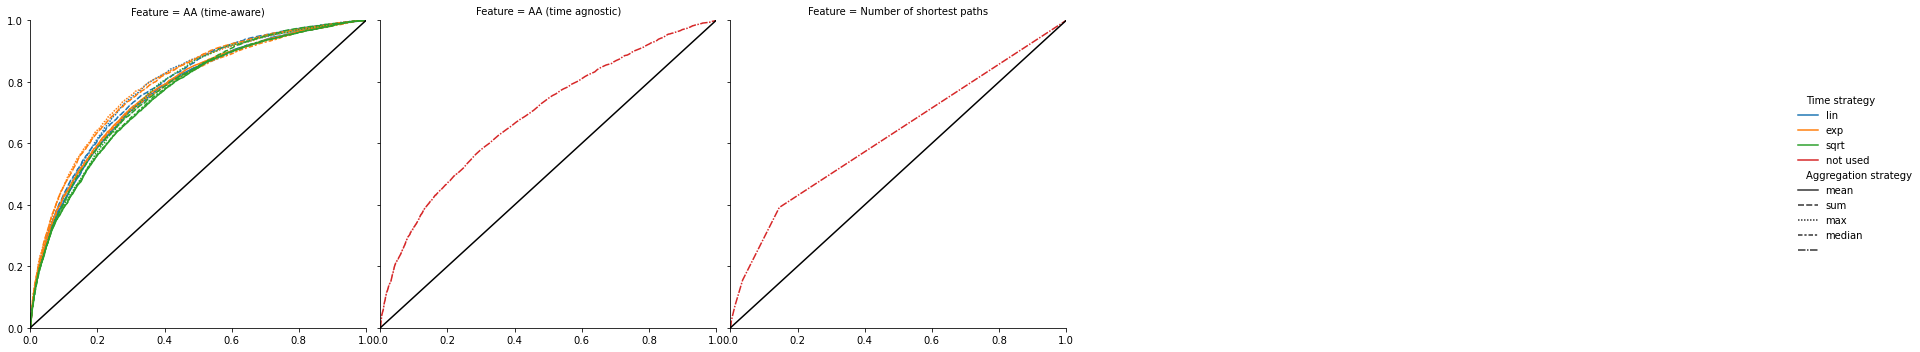

In [162]:
g = sns.relplot(
  data=data, x='FPR', y='TPR', hue='Time strategy', 
  style='Aggregation strategy', col='Feature', col_wrap=5, aspect=1, 
  kind='line')
g.map(plt.axline, xy1=(0,0), xy2=(1,1), c='black')
g.set(xlim=(0,1), ylim=(0,1))

## Table: AUC

In [6]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
pd.Series(
  {tuple(experiment.get_parameters().values()): 
   sklearn.metrics.roc_auc_score(y_sampled, experiment.scores) 
   for experiment in experiments}
).reset_index().groupby(['level_0']).mean()

,0
level_0,
AA (time agnostic),0.786723
AA (time aware),0.809072
